
Investigating solar installer marketing strategies using natural language processing
=============

This analysis explores residential solar PV marketing practices. Solar installers' roles are to not only carry out the technical aspects of installing the solar panels; they must also acquire new customers by marketing and selling to a diverse group of potential adopters looking to fulfill a diverse set of expectations from installing solar. The solar installer's marketing strategy must resonate with potential adopters who are looking for a variety of benefits from and information about installing solar PV. The solar installer gives a variety of information from spending less on electricity to reducing their environmental impact to how changes in policies will impact their investment. 

This analysis unsupervised staticstial topic modeling to classify solar installer tweets to better understand their marketing strategies and how they communicate with potential solar adopters. For instance, do solar installers conduct more inbound or outbound marketing? And within inbound marketing, which topics are referenced by individual companies and by industry as a whole. 


As tweets have a timestamp, analysis also derives trends in solar marketing.  

The project includes use the following natural language processing techniques to classify solar installers tweets into particular topics: **bag of words, LDA (Latent Dirichlet allocation), and K-MEANS**


I have borrowed from this analysis to conduct the research. 
- http://miriamposner.com/blog/very-basic-strategies-for-interpreting-results-from-the-topic-modeling-tool/
- https://www.dataquest.io/blog/matplotlib-tutorial/
- http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=7023421&url=http%3A%2F%2Fieeexplore.ieee.org%2Fxpls%2Fabs_all.jsp%3Farnumber%3D7023421
- http://journals.ama.org/doi/abs/10.1509/jmr.12.0106
- http://brandonrose.org/clustering

# Table of Contents
 <p><div class="lev1"><a href="#Investigating-solar-installer-marketing-strategies-using-natural-language-processing"><span class="toc-item-num">1&nbsp;&nbsp;</span>Investigating solar installer marketing strategies using natural language processing</a></div><div class="lev1"><a href="#Exploratory-Data-Analysis"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></div><div class="lev2"><a href="#Inbound-and-outbound-marketing"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Inbound and outbound marketing</a></div><div class="lev3"><a href="#Do-solar-installers-have-a-past-history-of-using-the-technology?"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Do solar installers have a past history of using the technology?</a></div><div class="lev3"><a href="#Is-solar-installer-twitter-usage-progressively-increasing?"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Is solar installer twitter usage progressively increasing?</a></div><div class="lev3"><a href="#Average-tweets-per-year-per-company"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Average tweets per year per company</a></div><div class="lev1"><a href="#What-is-the-aggregate-breakdown-for-solar-installer-marketing?"><span class="toc-item-num">3&nbsp;&nbsp;</span>What is the aggregate breakdown for solar installer marketing?</a></div><div class="lev1"><a href="#Preprocessing-features-for-NLP-analysis"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preprocessing features for NLP analysis</a></div><div class="lev2"><a href="#Controlling-for-customer-service-communication-in-Tweets."><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Controlling for customer service communication in Tweets.</a></div><div class="lev2"><a href="#Controlling-for-dates-and-times"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Controlling for dates and times</a></div><div class="lev2"><a href="#Replacing-company-name-or-twitter-hashtag-with-a-generic-text"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Replacing company name or twitter hashtag with a generic text</a></div><div class="lev2"><a href="#Replacing-person-name-with-generic-text"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Replacing person name with generic text</a></div><div class="lev2"><a href="#Replace-emails-with-standardized-text"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Replace emails with standardized text</a></div><div class="lev2"><a href="#Remove-consecutive-words"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Remove consecutive words</a></div><div class="lev2"><a href="#Replacing-geographic-region-with-a-text"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Replacing geographic region with a text</a></div><div class="lev1"><a href="#Prepare-tf-idf-and-count-vectorizers;-investigate-terms-by-count"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prepare tf-idf and count vectorizers; investigate terms by count</a></div><div class="lev2"><a href="#Count-Vecterizor"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Count-Vecterizor</a></div><div class="lev2"><a href="#TDIDF"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>TDIDF</a></div><div class="lev1"><a href="#Apply-k-means-clustering-to-determine-topics"><span class="toc-item-num">6&nbsp;&nbsp;</span>Apply k-means clustering to determine topics</a></div><div class="lev1"><a href="#Apply-topic-modeling-with-LDA-and-visualize-with-pyLDAvis-to-adjust-parameters"><span class="toc-item-num">7&nbsp;&nbsp;</span>Apply topic modeling with LDA and visualize with pyLDAvis to adjust parameters</a></div><div class="lev1"><a href="#Investigate-tweet-composition-by-topic"><span class="toc-item-num">8&nbsp;&nbsp;</span>Investigate tweet composition by topic</a></div><div class="lev2"><a href="#What-is-the-trend-in-solar-marketing-over-time?"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>What is the trend in solar marketing over time?</a></div><div class="lev2"><a href="#Visualizing-marketing-clusters"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Visualizing marketing clusters</a></div>

But first, I import everything I am going to need up front

In [236]:
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from textblob import TextBlob as blob
from scipy import stats
import pymysql.cursors
from datetime import datetime, timedelta
import datefinder

#from vaderSentiment.vaderSentiment import sentiment as vaderSentiment 

# sentiment analysis
from textblob.sentiments import NaiveBayesAnalyzer
#from pattern.en import sentiment, mood, modality, wordnet, ADJECTIVE

# text parsing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from spacy.en import English, STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tag import pos_tag
from collections import Counter

# modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
import lda
from sklearn.decomposition import PCA, LatentDirichletAllocation

# visualization
import pyLDAvis


import warnings
warnings.filterwarnings("ignore")


In [323]:

# query local dataset
connection = pymysql.connect(host="localhost", user="root", db="twitterresearch")

def query_db(query):
    with connection.cursor() as cursor:
        cursor.execute(query)
        return cursor.fetchall()
# #         result = [item[0] for item in cursor.fetchall()]
#         return result

# Exploratory Data Analysis


 


## Inbound and outbound marketing


This takes from manual classifacation of the tweets

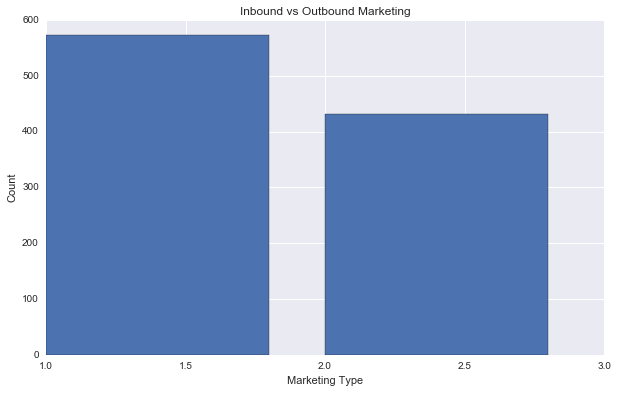

In [327]:
query = """SELECT LEFT(marketing_type , 1), COUNT(*)
            FROM tweets 
            WHERE marketing_type IS NOT NULL
            AND marketing_type NOT IN ('3-a','4-a','5-a')
            GROUP BY LEFT(marketing_type , 1);"""

results = dict(query_db(query))

plt.figure(figsize = (10, 6))
#sns.barplot(results.keys(), 'favorite_count', data = results.values())



plt.bar(results.keys(), results.values(), label='New Chart')
plt.xlabel('Marketing Type')
plt.ylabel('Count')
plt.title("Inbound vs Outbound Marketing");
plt.savefig('results/inbound_v_outbound.png')


### Do solar installers have a past history of using the technology?
When did solar installers start using twitter?

**Query** - Make a count for the date of the first tweet tweeted for each installer. 

**Observation** - Of the solar installers in the analysis, they peaked in adopting the technology around 2010. This does not necessarily mean that the installers no longer use technology. More likely, the installers in the analysis started using the technology early. 

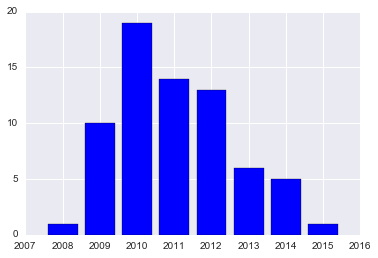

In [329]:
from collections import Counter

query = """SELECT twitter_id_fkey, YEAR(MIN(tweet_date)) FROM tweets
            GROUP BY twitter_id_fkey;"""

results = query_db(query)
results = Counter(dict(sorted(results)).values())

x = list(results.keys())
y = results.values()
width = 1/1.5
plt.bar(x,y, align='center', color="blue")

# get the ticks right
xx, locs = plt.xticks()
ll = ['%.0f' % a for a in xx]
plt.xticks(xx, ll)


plt.savefig('results/twitter_adoption.png')

### Is solar installer twitter usage progressively increasing?

Are solar installers using twitter more each year?

**Query** Group the number of tweets by year and get count.

**Observation** - Solar installers are progressively using the tools more. However, there is a cumulative effect as more installers are enterring the industry. A more complete analysis includes is the average number of tweets per installer each year.

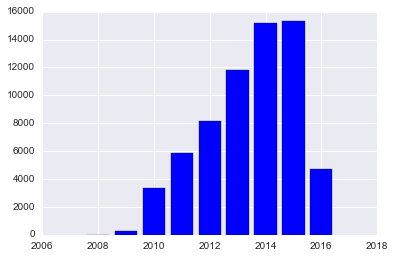

In [325]:
query = """SELECT YEAR(tweet_date), COUNT(*) FROM tweets
            GROUP BY YEAR(tweet_date);"""

results = dict(query_db(query))
x = list(results.keys())
y = results.values()
width = 1/1.5
plt.bar(x,y, align='center', color="blue")

# get the ticks right
xx, locs = plt.xticks()
ll = ['%.0f' % a for a in xx]
plt.xticks(xx, ll)

plt.savefig('results/number_tweets_by_year.png')

### Average tweets per year per company

**Observation** the number of tweets per year per company is also increasing. 

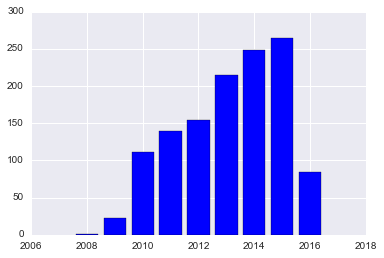

In [336]:
query = """SELECT YEAR(tweet_date), COUNT(*) / COUNT(DISTINCT twitter_id_fkey) as num_companies FROM tweets
            GROUP BY YEAR(tweet_date);"""

results = dict(query_db(query))
x = list(results.keys())
y = results.values()
width = 1/1.5
plt.bar(x,y, align='center', color="blue")

# get the ticks right
xx, locs = plt.xticks()
ll = ['%.0f' % a for a in xx]
plt.xticks(xx, ll)

plt.savefig('results/average_tweets_per_year_per_company.png')

In [337]:
# put tweets into a dataframe
query = """SELECT tweets.tweet, tweets.tweet_date, tweets.retweeted, tweets.retweet_count, tweets.favorited, tweets.favorite_count, installers.installer_name, tweets.marketing_type 
            FROM tweets 
            LEFT JOIN installers 
            ON tweets.twitter_id_fkey = installers.twitter_id"""

results = query_db(query)
tweet, tweet_date, retweeted, retweet_count, favorited, favorite_count, installer_name, marketing_type  = zip(*results)
data = [tweet, tweet_date, retweeted, retweet_count, favorited, favorite_count, installer_name, marketing_type ]

df = pd.DataFrame(data)
df = df.transpose()
cols = ['text', 'tweet_date', 'retweeted', 'retweet_count', 'favorited', 'favorite_count', 'company', 'marketing_type']
df.columns = cols

In [338]:
def add_metadata(df):
    """Add date, is retweet, month, and week features to df."""
    # add date as datetime object
    df.loc[:, 'date'] = df.loc[:, 'tweet_date'].apply(lambda x: pd.to_datetime(x).date())
    
    # add month
    df.loc[:, 'month'] = df.loc[:, 'date'].apply(lambda x: x.replace(day = 1))

In [244]:
add_metadata(df)

Who uses Twitter more?

In [245]:
def plot_time(counted):
    """Plot tweets over time."""
    cands = ['SolarCity']
    plt.figure(figsize = (10, 6))
    for cand in cands:
        plt.plot(counted.loc[cand, 'text'], label = cand)
    plt.legend(loc = 'best')
    plt.show()

Do particular solar installers get retweeted more?


What is the history of their retweets over time?

What are the most retweeted tweets? Is there a common thread? Are they from a particular company? Does that company have something special about them? 

In [246]:
# show original tweets
# df

retweets = df[df['text'].str.contains('RT', na=False) == False]

list_most_retweeted = retweets[['text', 'company', 'retweet_count']].sort_values(['retweet_count'], ascending=False)

Relationship between tweets and revenue?

# What is the aggregate breakdown for solar installer marketing?

This section segments the analysis

# Preprocessing features for NLP analysis

Tweets have 

Define functions to tokenize and add sentiment, modality, and mood scores.

TagLDA: Bringing document structure knowledge into topic models http://pages.cs.wisc.edu/~jerryzhu/pub/taglda.pdf
Content Marketing LDA - https://www.seoreseller.com/blog/content-marketing-through-topic-modeling

Reducing dimensionality
http://fastml.com/dimensionality-reduction-for-sparse-binary-data/

Bag of words implementation

http://fastml.com/classifying-text-with-bag-of-words-a-tutorial/

In [72]:
# get only the top tweets for intial analysis
# df = df.head(200)

In [73]:
def get_sentences(text):
    """Return list of sentences in tweet."""
    sents = sent_tokenize(text)
    return [sent for sent in sents if re.search('[a-zA-Z]', sent) != None]

## Controlling for customer service communication in Tweets.

A considerable number of the tweets are user mentions -- Tweets where the user mentions a particular user. These tweets are most likely a customer service. To help better categorize these tweets. We will replace the twitter handle for the person that they are contacting with the text "usermention"

In [93]:
def remove_user_mention(text):
    """
    Add annotation and remove the username to tweets 
    that are user mention. 
    """    

    if text[0] == '@' and len(text) > 0:
        try:
            split_tweet = text.split(" ")
            twitter_handle = split_tweet[0]
            text = ' '.join(['usermention' if word==twitter_handle else word for word in split_tweet])
        except Exception as e:
            print(text)
                
    twitter_handle = r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9_]+) '
    text = re.sub(twitter_handle, 'twitterhandle ', text, flags=re.IGNORECASE)
    
    return text

text = "@LiveGreenMom: Let's hear it for #GREEN #FF friends! @GreenEnergyNews @vyouz @denversolarguy @RarePlanet @TaigaCompany 2972,rt @solarbizdaily ff @solarfeed @solarindustry @solarfund @greenbizdaily green"
remove_user_mention(text)

"usermention Let's hear it for #GREEN #FF friends! twitterhandle twitterhandle twitterhandle twitterhandle twitterhandle 2972,rt twitterhandle ff twitterhandle twitterhandle twitterhandle twitterhandle green"

## Controlling for dates and times

a lot of the tweets reference a particular time or date. This is because they are typically referencing a date or time that an event will be held. These tweets should be grouped together as the date or the time that event occurred is not that important. It is more important to know that there was a particular event held on a date.

- date reference vs time reference 'May 23rd at 8:00am'

TODO:
- what is the difference between personal message (pm) and pm time
- What to do with the th


In [75]:
def control_datetime(text):
    
    days = ['monday', 'mon', 'tuesday', 'tues', 'wednesday', 'wed', 'thursday', 'thurs', 'friday', 'fri', 'saturday', 'sunday', 'tomorrow', 'yesterday', 'weekend']
    months = ['january', 'jan', 'february', 'feb', 'march', 'mar', 'april', 'apr', 'may', 'june', 'jun', 'july', 'jul', 'august', 'aug', 'september', 'sep', 'october', 'oct', 'november', 'nov', 'december', 'dec']
#     time = ['pm', 'am', 'noon', 'morning', 'afternoon', 'evening', 'night', 'today']

    for date in (days + months):
        date = r'(?<![a-z])' + date + '(?![a-z])'
        text = re.sub(date, 'datereference', text, flags=re.IGNORECASE)
        
    time = r'\d{1,2}(?:(?:am|pm)|(?::\d{1,2})(?: am| pm)?|(?::\d{1,2})(?:am|pm)?)'
    text = re.sub(time, 'timereference', text, flags=re.IGNORECASE)
    
    return text
    
text = "Tomorrow at 9:00 am until &lt;br /&gt;fried, May 23 at 5:00 pm. Come... http://bit.ly/cqi6Lr"
control_datetime(text)
    

'datereference at timereference until &lt;br /&gt;fried, datereference 23 at timereference. Come... http://bit.ly/cqi6Lr'

## Replacing company name or twitter hashtag with a generic text
a lot of tweets reference particular places


In [113]:
# list of companies

def create_company_list():
    companies = set(df.company.drop_duplicates())
    for c in companies:
        words = u' '.join(c.lower().split(" "))
        words_no_space =  u''.join(words.replace(".","").split(" "))
        companies = companies.union({words, words_no_space})

    companies = companies.union({u'ameco', u'sierra pacific', u'herca',u'hemetsolar', u'asi hastings', u'solstice', u'vivint solar', u'vivintsolar', u'vivint', u'sunline',  u'trinitysolar', u'trinity', u'rgsenergy', u'rg', u'sullivansolar', u'solare', u'solarenergy',u'recsolar', u'rec', u'sullivan', u'joule', u'thesolarco', u'solaruniverse', u'gci', u'green convergence', u'solare energy', u'solarcity', u'pacificsolar', u'ross', u'ross group', u'namaste', 'asi hastings', u'asi', u'verengosolar', u'gosolaire', u'solaire', u'sunationsolarchoice', u'sunationsolar', u'acroenergy', u'sunation', u'namast',  u'luminalt',  u'solar alliance', u'solar alliance of america', u'quality home improvement', u'solstice story'})
    return companies

companies = create_company_list()

def replace_company_name(text):
    """
    Apply regex to each company name.
    """
    for company in (companies):

        company = r'(?<![a-z])' + company + '(?![a-z])'
        text = re.sub(company, 'companyreference', text, flags=re.IGNORECASE)
    
    return text
    
text = 'join vivintsolar today at our event'    
replace_company_name(text)

'join companyreference today at our event'

## Replacing person name with generic text


http://www.matthewjockers.net/2013/04/12/secret-recipe-for-topic-modeling-themes/

In [77]:
# names = ({u'lynn', u'lynn jurich', u'jurich', u'lyndon rive', u'lyndon', u'rive', u'ceo', u'founder', u'ceo lyndon', u'ceo lyndon rive', u"danny kennedy", u"danny", u"kennedy", u"dannyksfun", u'rainarusso', u'carlsiegrist'})
# add_names = set(open('data/additional_stop_word.txt','r').read().split(", "))
# names_longer_3 = set([name for name in add_names if len(name) >= 4])

# names = names.union(names_longer_3)


# def replace_company_name(text):
#     for name in names:

#         name = r'(?<![a-z])' + name + '(?![a-z])'
#         text = re.sub(name, 'namereference', text, flags=re.IGNORECASE)
    
#     return text


# text = 'jeff jingleheimer smith'
# replace_company_name(text)

## Replace emails with standardized text

In [78]:
email_pattern = re.compile('([\w\-\.]+@(\w[\w\-]+\.)+[\w\-]+)')

def get_emails(text):
    """Returns an iterator of matched emails found in string s."""
    for match in email_pattern.findall(text):
        
        text = text.replace(match[0], 'useremailaddress')
    
    return text

text = 'this is an emails matt.a.stringer@gmail.com'
get_emails(text)

'this is an emails useremailaddress'

## Remove consecutive words

Some words are together in a group, for instance 'datereference datereference'. This is either due to the bag of word processing or mistype

In [79]:
def remove_duplicate(text):
    text_list = text.split(" ")
    new_text_list = text_list
    for num, t in enumerate(text_list):
        if num < len(text_list)-1:
            if text_list[num+1] == t:
                text_list.remove(t)

    return ' '.join(text_list)     

text = 'come to solar open house in honolulu near kamiloiki park datereference datereference datereference from timereference to timereference check out hyperlink'
# text = 'datereference at timereference until &lt;br /&gt;datereference datereference 23 at timereference. Come... http://bit.ly/cqi6Lr'
remove_duplicate(text)

'come to solar open house in honolulu near kamiloiki park datereference datereference from timereference to timereference check out hyperlink'

## Replacing geographic region with a text


This looks like a good example. https://pypi.python.org/pypi/geograpy/0.3.7
Package not currently not yet ready for Python3

Current implemtation is only implementing a list of text


In [80]:
states = set(['Alabama', 'AL', 'Alaska', 'AK','Arizona', 'AZ', 'Arkansas', 'AR', 'California', 'CA', 'Colorado', 'CO', 'Connecticut','Delaware', 'DE', 'Florida','FL','Georgia', 'GA', 'Hawaii', "Hawai'i", 'hawaiian' 'Idaho', 'ID', 'Illinois', 'IL', 'Indiana', 'ID', 'Iowa', 'IA', 'Kansas', 'KA', 'Kentucky', 'KY', 'Louisiana', 'LA', 'Maine', 'ME', 'Maryland', 'MD', 'Massachusetts', 'MA', 'Michigan', 'MI', 'Minnesota', 'MN', 'Mississippi', 'MS', 'Missouri', 'MS', 'Montana', 'MT', 'Nebraska','NE', 'Nevada', 'NV', 'New Hampshire', 'NH', 'New Jersey', 'NJ', 'New Mexico', 'NM', 'New York', 'NY', 'North Carolina', 'NC', 'North Dakota', 'ND', 'Ohio','OH',  'Oklahoma','OK','Oregon', 'OR','Pennsylvania','PA', 'Rhode Island','RI', 'South Carolina', 'SC', 'South Dakota','SD', 'Tennessee', 'TN', 'Texas','TX', 'Utah','UT', 'Vermont','VT', 'Virginia','VA', 'Washington','WA', 'West Virginia','WV', 'Wisconsin','WI', 'Wyoming', 'WY' ])
states = states.union({''.join(state.split(" ")) for state in states})

cities = set([ u'athens',u'new orleans', u'san diego', u'san francisco', u'grass valley',  u'ventura county',  u'santa clarita',u'santa barbara', u'san diego', u'nyc', u'la', u'oakland', u'san jose', u'fremont',  u'bay area', u'san dimas', u'los angeles', u'sacramento', u'fresno', u'long island', u'phoenix', u'ca', u'sf', u'marin', u'palm springs', u'sonoma', u'boulder', u'spec city', u'camarillo', u'li', u'seattle', u'austin', u'orange county', 'denver'])
cities = cities.union({''.join(city.split(" ")) for city in cities})

def replace_geography(text):
    text = replace_states(text)
    text = replace_cities(text)
    return text
    
def replace_states(text):    
    for state in states:
        state = r'(?<![a-z])' + state + '(?![a-z])'
        text = re.sub(state, 'statename', text, flags=re.IGNORECASE)   
    return text

def replace_cities(text):

    for city in cities:
        city = r'(?<![a-z])' + city + '(?![a-z])'
        text = re.sub(city, 'cityname', text, flags=re.IGNORECASE)
    return text
        

text = 'Calcuated 10 $10.8B invested in cleantech in San Francisco, CA and athens, GA in 2008 with 20% increase by matt.a.stringer@gmail.com'
text = replace_geography(text)


In [283]:

    
def replace_solar(text):    
    solar_words = ({u'pv', u'solar pv', u'solar array', u'rooftop solar',  u'photovoltaic', 'solar panels', 'solar install', 'solar system', 'solar array'})
    
    solar_words = solar_words.union(set([''.join(word.split(" ")) for word in solar_words]))
    
    for word in solar_words:
        words = r'(?<![a-z])' + word + '(?![a-z])'
        text = re.sub(words, 'solarpanelsreference', text, flags=re.IGNORECASE)   
    return text

text = 'this is a photovoltaic solararray'
replace_solar(text)

'this is a solarpanelsreference solarpanelsreference'

In [217]:
nlp = English()
stop = STOPWORDS
punct = {p for p in string.punctuation if p != '@' and p != '#'}

In [218]:
def get_tokens(text):  
    """
    Return lemmatized tokens for each review.
    """
    text = ' '.join(text.lower().split()) # make text lower case
    
    text = get_emails(text) # replace email address
    text = replace_geography(text)
    text = replace_company_name(text)
    
    text = control_datetime(text) # replace dates with str datetimes
    text = remove_user_mention(text) # place replace replies with the names usermentions
    text = replace_solar(text)
    
#     text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', 'hyperlink', text)# replace urls with str hyperlink
    
    # need to figure out what to do with stuff that points back to their blog or company website
    text = re.sub(r"http\S+", 'hyperlink', text)# replace urls with str hyperlink
    text = re.sub(r"https\S+", 'hyperlink', text)# replace urls with str hyperlink
    text = re.sub(r"www\S+", 'hyperlink', text)# replace urls with str hyperlink 

    words = re.sub("[^a-zA-Z@$%']", " ", text) # remove everything except letters, hashtags, @ and $

    try:
        tokens = [token.lemma_ for token in nlp(words)] # get lemmas
    except:
        tokens = [token.lemma_ for token in nlp(words.decode('utf8'))] # get lemmas

    filtered = [t for t in tokens if t != '' and t != ' ' and t != '\n' and t != '\n\n'] # remove any remaining spaces
    filtered = [t.strip() for t in filtered] # remove phone numbers from analysis   ?
    filtered = [x for x in filtered if x]
    

# filtered = [t for t in filtered if any(letter.isalpha() for letter in t)] # remove numbers without any letters attached
    filtered_text = ' '.join(filtered)
    filtered_text = remove_duplicate(filtered_text) # remove duplicate text
    return filtered_text



def remove_proper_nouns(text):
    tagged_sent = pos_tag(text.split())
    # [('Michael', 'NNP'), ('Jackson', 'NNP'), ('likes', 'VBZ'), ('to', 'TO'), ('eat', 'VB'), ('at', 'IN'), ('McDonalds', 'NNP')]
    nopropernouns = [word for word,pos in tagged_sent if pos != 'NNP']
    return ' '.join(nopropernouns)


In [284]:

text = "$4.8B wasn't invested in cleantech in San Francisco, california  and Hawai'i 2008 with Sammy's 20% increase by matt.a.stringer@gmail.com http://t.co/asdfasd"
text2 = "RT @AltEnergyWebPar: Residential-solar: Hillary Clinton, Julia Gillard Sign $50 Million Solar Power Pact http://bit.ly/arIegw Full http: ..."
text3 = "RT @BloombergNEF: Excited for today's roundtable w/ @CohnReznickRE in NY to discuss financial innovation in the US renewable industry! http"
text4 = "Hey @greggrunberg check out www.Sungevity.com we're a leading California solar provider and offer free solar quotes via the web in 24 hrs"
text5 = "Tomorrow at 10:00 am until &lt;br /&gt;Sunday, May 23 at 5:00 pm. Come... http://bit.ly/cqi6Lr"
text6 = "Solar open house in Kaimuki this weekend Sunday, June 5, 12pm-4pm.  3824 Pahoa Ave Honolulu, HI."
text7 = 'Jan Newman &amp; Paul Dickson http://t.co/tvAGyZ1QpL #VivintSolar #leadership #venturacounty'
get_tokens(text7)


'datereference newman amp paul dickson hyperlink vivintsolar leadership cityname'

In [285]:
def get_features(df):
    
    # remove proper nouns from analysis
#     %time df.loc[:, 'text_no_proper_nouns'] = df.loc[:, 'text'].apply(remove_proper_nouns)
    
    
    # add sentences
    %time df.loc[:, 'sentences'] = df.loc[:, 'text'].apply(get_sentences)
    
    # add tokens
    %time df.loc[:, 'tokens'] = df.loc[:, 'text'].apply(get_tokens)
    

    
    # add sentiment, subjectivity, modality, and mood scores by sentence
    #%time df.loc[:, 'sentiment'] = df.loc[:, 'sentences'].apply(get_polarity)
    
    # count number of characters
    %time df.loc[:, 'num_chars'] = df.loc[:, 'tokens'].apply(lambda x: pd.to_numeric(len(x), errors='coerce'))
    
    # count number of tokens
    %time df.loc[:, 'num_tokens'] = df.loc[:, 'tokens'].apply(lambda x: pd.to_numeric(len(x.split()), errors='coerce'))
    
    # count number of hyperlinks
    %time df.loc[:, 'num_hyperlinks'] = df.loc[:, 'tokens'].apply(lambda x: x.split().count('hyperlink'))

In [286]:
get_features(df)

CPU times: user 7 s, sys: 151 ms, total: 7.15 s
Wall time: 7.16 s
CPU times: user 3min 25s, sys: 2.67 s, total: 3min 28s
Wall time: 3min 29s
CPU times: user 783 ms, sys: 10.7 ms, total: 793 ms
Wall time: 795 ms
CPU times: user 874 ms, sys: 2.14 ms, total: 877 ms
Wall time: 876 ms
CPU times: user 167 ms, sys: 839 µs, total: 168 ms
Wall time: 168 ms


In [287]:
# confirm that we have all the companies on the list
companies = df.company.drop_duplicates()
# companies.tolist()

In [288]:
# only analyze tweets with more than 75 characters
print(len(df))
long_tweets = df[df['num_chars'] > 75.0]
long_tweets = long_tweets[~long_tweets.company.isin(['Quality First Home Improvement Inc.', 'GRID Alternatives', 'Solar Alliance of America', 'SunEdison'])]

# # create list of companies that will be analyzed
# companies = long_tweets.company.drop_duplicates()


64682


In [289]:
t = long_tweets[long_tweets['tokens'].str.contains('pacific', na=False) == True]
t[['tokens', 'text']].to_csv('out.csv')


Pickle for future reloading. Save time on preprocessing

In [290]:
long_tweets.to_pickle('data/long_tweets.pkl')

In [291]:
long_tweets = pd.read_pickle('data/long_tweets.pkl')


In [266]:
# # just look at the big guys
# companies_to_analyze =['Sungevity', 'SolarCity', 'Vivint Solar ', 'SunRun', 'Trinity Solar ', 'Solar Universe Inc.', 'Real Goods Solar ', 'Solar Universe Inc.', 'Alternate Energy Inc']
# long_tweets = long_tweets[long_tweets.company.isin(companies_to_analyze)]
# len(long_tweets)

# Prepare tf-idf and count vectorizers; investigate terms by count

Remove stop words from analysis

In [292]:
# add additional stop words
stop = stop.union({ u'hyperlink', u'rt', u'amp'})

stop = stop.union({u'greentechmedia', u'cleantechnica', u'solarchat', u'solarpowerworld', u'solarpowerworld', u'renewable energy', u'clean energy'})

In [293]:
stop = stop.union({u'ice pop truck', 'ice pop', 'ice', 'pop'})

# remove the names (possibly in the future I need to replace the names)
stop = stop.union({u'lynn', u'lynn jurich', u'jurich', u'lyndon rive', u'lyndon', u'rive', u'ceo', u'founder', u'ceo lyndon', u'ceo lyndon rive', u"danny kennedy", u"danny", u"kennedy", u"dannyksfun", u'rainarusso', u'carlsiegrist'})
stop = stop.union(set(open('data/additional_stop_word.txt','r').read().split(", ")))

## Count-Vecterizor

Convert a collection of text documents to a matrix of token counts
This implementation produces a sparse representation of the counts using scipy.sparse.coo_matrix.
If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.




In [294]:
# come back and check min df

def create_count_matrix(df, max_features_count=None, comp=None):
    count_vect = CountVectorizer(analyzer = "word", 
                                 tokenizer = None, 
                                  preprocessor = None, 
                                       stop_words = stop, 
                                       max_features = max_features_count,
                                       ngram_range = (1, 3), 
                                       min_df = 1) 
    if comp == None:
        matrix = count_vect.fit_transform(df.tokens)
        
    else:
        matrix = count_vect.fit_transform(df[df.company == comp].tokens)
    
    return count_vect, matrix    

In [295]:
count_vect, count_matrix = create_count_matrix(long_tweets)

# Review total dimensionality of the analysis
print("total num tweets: ", count_matrix.shape[0])
print("total dimensionality: ", count_matrix.shape[1])

total num tweets:  40795
total dimensionality:  396784


prepare list of most common words for each company

In [296]:
# #get word count

# for comp in companies:
#     print('\n', comp, '\n')
    
#     try:
#         count_vect, matrix = create_count_matrix(df, max_features_count=None, comp=comp)
#         grams = count_vect.get_feature_names()
#         dist = np.sum(matrix.toarray(), axis = 0)

#         grams_sorted = sorted(zip(grams, dist), key = lambda x: x[1], reverse = True)[:20]
        
#         print(grams_sorted)
#     except ValueError:
#         pass

In [297]:
# show most popular words for each company

# for c in companies:
#     try:
#         get_word_count(c, long_tweets) 
#     except Exception:
#         c
    

## TDIDF

I set the parameters for the frequency-inverse document frequency (tf-idf) vectorizer, and get the tweets into a tf-idf matrix. To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. 

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:
- **min_idf:** this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. 
- **stop_words** - add stop words defined earlier
- **max_df**
- **ngram_range:** this just means I'll look at unigrams, bigrams and trigrams. 

Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses.

In [298]:
def create_tdidf_matrix(df, comp=None):
    vect = TfidfVectorizer(min_df = 2, 
                           stop_words = stop,
                           use_idf = True, 
                           tokenizer = None, 
                           ngram_range=(1, 3))

    if comp == None:
        matrix = vect.fit_transform(df.tokens)
        
    else:
        matrix = count_vect.fit_transform(df[df.company == comp].tokens)
    
    return vect, matrix   

    

In [299]:
count_vect_tdidf, tfidf_matrix = create_tdidf_matrix(long_tweets)


# Review total dimensionality of the analysis
print("total num tweets: ", tfidf_matrix.shape[0])
print("total dimensionality: ", tfidf_matrix.shape[1])


total num tweets:  40795
total dimensionality:  66246


# Apply k-means clustering to determine topics

I first chose k-means. K-means initializes with a pre-determined number of clusters. Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.


I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima.

In [257]:
def km_means(vect, matrix, print_output=False, true_k=5, comp=None):

    grams = vect.get_feature_names()
    km = KMeans(n_clusters=true_k)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    
    if print_output:
        print('\n', comp)
        for i in range(true_k):
            print("\nCluster %d:" % i)
            try:
                print(', '.join([grams[ind] for ind in order_centroids[i, :25]]))
            except IndexError as e: 
                print(len(order_centroids[i]))  
            print()
    return km
    


In [258]:
km_countvect = km_means(count_vect, count_matrix,  print_output=True, true_k=15, comp=None)


 None

Cluster 0:
hill air force, air force base, air, air force, base, hill, hill air, force, force base, solar worker, doe, worker check, worker check fb, solar worker check, fb info, train, usermention twitterhandle hill, worker, goal train solar, goal train, announcement, base today doe, fb, base today, today


Cluster 1:
solar, twitterhandle, statename, power, companyreference, energy, solar power, job, today, save, green, statename solar, solar energy, datereference, news, twitterhandle solar, year, solar solar, install, industry, solar today, install solar, state, green solar install, green solar


Cluster 2:
solar, energy, power, datereference, solarpanelsreference, day, year, save, gosolar, today, cityname, solar power, help, time, clean, job, world, industry, solar energy, electricity, green, customer, check, use, work


Cluster 3:
tweet, story, ilovesolar, solar, ilovesolar story, story datereference, datereference feature, support, ilovesolar story datereference, twitterha

In [259]:
km_tdidf_vect = km_means(count_vect_tdidf, tfidf_matrix, print_output=True, true_k=15, comp=None)


 None

Cluster 0:
usermention, thanks, dm, address, thank, hi, usermention thanks, usermention hi, email, look, send, usermention twitterhandle, statename, useremailaddress, reach, help, info, sure, usermention thank, contact, customer, hear, twitterhandle, email useremailaddress, share


Cluster 1:
year, solar, year solar, twitterhandle, statename, solar year, year twitterhandle, year ago, ago, industry, energy, companyreference, grow, day, save, seia, year old, old, time, day year, customer, big, growth, billion year, job


Cluster 2:
companyreference, solar, statename, twitterhandle, companyreference solar, customer, companyreference twitterhandle, solar companyreference, companyreference customer, companyreference statename, companyreference blog, blog, twitterhandle companyreference, cityname, job, check, today, bring, post, usermention, help, business, day, work, hire


Cluster 3:
solar, statename, twitterhandle, industry, statename solar, gosolar, job, solar industry, twitterha

In [ ]:
# first = get_clusters_counts('SunRun', long_tweets, 20)

In [ ]:
# plot k vs. intertia
inertias = []
for k in range(1, 50):
    mod = km_means(count_vect, print_output=False, true_k=k, comp=None)
    inertias.append(mod.inertia_)

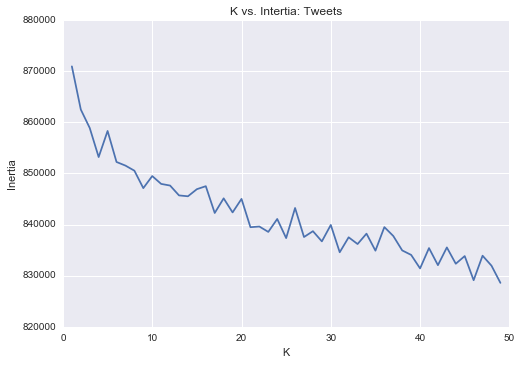

In [29]:
plt.plot(range(1,50), inertias)
plt.title('K vs. Intertia: Tweets')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

With tdidf

In [30]:
# get_clusters_tfidf('SolarCity', long_tweets, 10)

In [ ]:
tfidf_inertias = []
for k in range(1, 50):
    mod = km_means(count_vect_tdidf, print_output=False, true_k=k, comp=None)
    tfidf_inertias.append(mod.inertia_)

In [ ]:
plt.plot(range(1,51), tfidf_inertias)
plt.title('K vs. TDIDF Intertia: Tweets')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

# Apply topic modeling with LDA and visualize with pyLDAvis to adjust parameters


In [275]:
def print_top_words(model, feature_names, n_top_words = 20):
    """Print top words in each topic."""
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [276]:
def get_doc_topics(doc_topic_dist):
    """Return list of topics for documents, given doc topic distribution"""
    return [np.argmax(topic) for doc, topic in enumerate(doc_topic_dist)]

All tweets; run topic modeling with each tweet as separate document

In [300]:
def get_topics_lda(docs, df, n_topics = 4):   
    count_vect = CountVectorizer(analyzer = "word",
                                 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = stop, 
                                       max_features = 10000,
                                       ngram_range = (1, 5), 
                                       min_df = 10) 
    matrix = count_vect.fit_transform(docs)
    vocab = count_vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior = .001, max_iter=5,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)
    

#     print("\nTopics in LDA model:", cand)
#     print_top_words(lda, vocab)
    
    # prepare pyLDAvis stuff 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = docs.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, vocab, doc_topic_dists, prepared

In [301]:
# with tf-idf

# with tf-idf
def get_topics_lda_tfidf(docs, df, n_topics = 4):   
    vect = TfidfVectorizer(max_df = 0.8, 
                           max_features = 200000,
                           min_df = 5, 
                           stop_words = stop,
                           use_idf = True, 
                           tokenizer = None, 
                           ngram_range=(1, 3))
    
    matrix = vect.fit_transform(docs)
    vocab = vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior = .001, max_iter=20,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)
    
    print("next")
    

    
    # prepare pyLDAvis stuff 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = docs.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, vocab, doc_topic_dists, prepared
    
    
    

In [53]:
all_lda, vocab, all_doc_topics, all_prepared= get_topics_lda(long_tweets.tokens, long_tweets, 20)

Using TFIDF

In [302]:
all_lda_tfidf, vocab_tfidf, all_doc_topics_tfidf, all_prepared_tfidf = get_topics_lda_tfidf(long_tweets.tokens, long_tweets, 15)
print_top_words(all_lda_tfidf, vocab_tfidf)

next

Topic #0:
solar, energy, statename, twitterhandle, power, clean, world, electric, solar power, solarpanelsreference, large, clean energy, state, plant, use, business, year, car, cost, fuel

Topic #1:
usermention, dm, net, metering, net metering, address, solar, day, statename, email, hear, benefit, thank, energy, send, contact, useremailaddress, value, earth, double

Topic #2:
post, blog, blog post, capacity, solar, facebook, enter, lennox, career, gw, revolution, photo, win, solarpanelsreference, picture, spread, solar capacity, flight, album, plane

Topic #3:
solar, twitterhandle, statename, usermention, companyreference, thanks, cityname, customer, power, energy, day, solarpanelsreference, datereference, gosolar, today, year, check, look, time, company

Topic #4:
datereference, solar, rec, timereference, house, th, twitterhandle, cityname, join, rec solar, instal, today, ameco, datereference th, solarpanelsreference, open, statename, sierraclub, free, companyreference

Topic #

In [313]:
topic_names = {0: "solar news",
              1: "direct questions about the solar",
              2: "solar blog",
              3: "event reference",
              4: "open house reference",
              5: "unknown 1",
              6: "negative customer service",
              7: "how solar works",
              8: "solar tax credits",
              9: "unknown 2",
              10:"unknown 3",
              11:"Save money solar",
              12:"customer support",
              13:"rates/net metering",
              14:"unknown 4" 
              }

In [314]:
pyLDAvis.display(all_prepared_tfidf)

In [315]:
tweet_topics = get_doc_topics(all_doc_topics_tfidf)


In [306]:
long_tweets['topic'] = tweet_topics

long_tweets['topic_name'] = long_tweets['topic'].map(topic_names)
# show 
# long_tweets[['text','tokens', 'topic', 'topic_name']].head(20)

# Investigate tweet composition by topic

- Topics over time by candidate (streamgraph)
- Topics over time by topic (stacked bar chart)
- Sentiment over time (grouped bar chart)
- Imperativeness/call to action percentage over time (grouped bar chart)

In [307]:
# groups = long_tweets.groupby(['topic'])
# groups.value_counts()

In [308]:
def get_list_time(df):
    return df[df.month >= pd.to_datetime('2010-01-01').date()].month.drop_duplicates().sort_values().tolist()

def get_topics(df, column_name):
    return df[column_name].drop_duplicates().sort_values().tolist()

In [309]:
def make_analysis_array(df, grouping):
    import collections
    df = df[['month', grouping]]
    df = df[df[grouping].notnull() ]
    months_in_analysis = get_list_time(df)
    
    data = []

    for topic, group in df.groupby(grouping):

        topic_month_count = dict(group['month'].value_counts())

        complete_topic_month_count = { month: topic_month_count[month] if month in topic_month_count else 0 for month in months_in_analysis }
        assert len(complete_topic_month_count) == len(months_in_analysis)

        new_row = np.array([complete_topic_month_count[month] for month in sorted(complete_topic_month_count)])

        data.append(new_row)

    return np.array(data)

In [317]:
def make_stacked_line_chart(x,y,topics, filename):
    y_stack = np.cumsum(y, axis=0)   # a 3x10 array
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(111)

    list_of_colors = ["#CC6666", "#1DACD6", "#6E5160", "#181B2D", "#565762", "#f4a460", "#A29FA6", "#C66C1F", "#D5C71F", "#3B9DFF", "#6295A8", "#7CC8FF", "#6D4D17"]

    for t in range(len(topics))[:10]:
        if t == 0:
            ax1.fill_between(x, 0, y_stack[0,:], facecolor="#CC6666", alpha=.7, label=topic_names[topics[t]])
        else:
            ax1.fill_between(x, y_stack[t-1,:], y_stack[t,:], facecolor=list_of_colors[t], alpha=.7, label=topic_names[topics[t]])
    
    handles, labels = ax1.get_legend_handles_labels()

    # reverse the order
    ax1.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.title("Solar Installer Marketing")
    
    plt.savefig(filename)

## What is the trend in solar marketing over time?

What groups appear more often? When do they appear? 

In [318]:
# x = get_list_time(long_tweets)
# y = make_analysis_array(long_tweets, 'marketing_type')
# topics = get_topics(long_tweets, 'marketing_type')
# make_stacked_line_chart(x,y,topics, 'marketing_type.png')

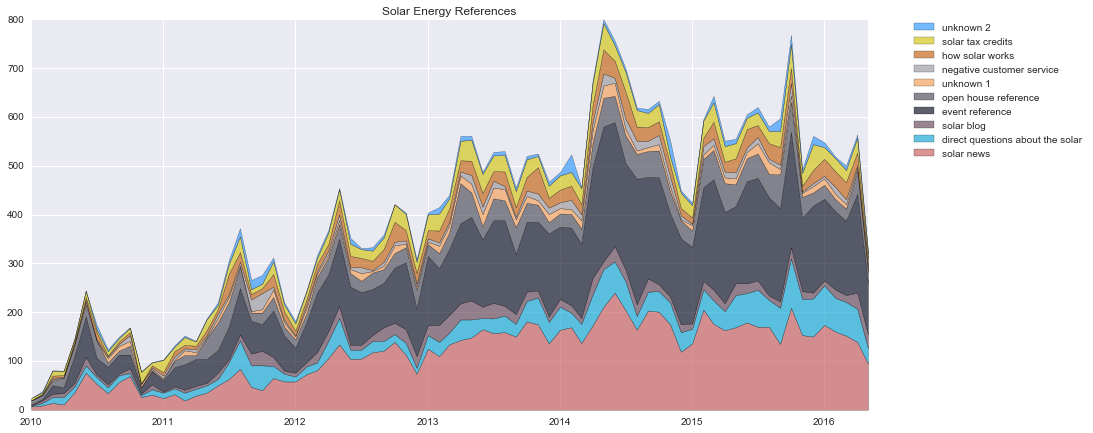

In [320]:
x = get_list_time(long_tweets)
y = make_analysis_array(long_tweets, 'topic')
topics = get_topics(long_tweets, 'topic')
make_stacked_line_chart(x,y,topics, 'results/lda_topic_model_overtime.png')

Show the clusters.

In [316]:
print_top_words(all_lda_tfidf, vocab_tfidf)


Topic #0:
solar, energy, statename, twitterhandle, power, clean, world, electric, solar power, solarpanelsreference, large, clean energy, state, plant, use, business, year, car, cost, fuel

Topic #1:
usermention, dm, net, metering, net metering, address, solar, day, statename, email, hear, benefit, thank, energy, send, contact, useremailaddress, value, earth, double

Topic #2:
post, blog, blog post, capacity, solar, facebook, enter, lennox, career, gw, revolution, photo, win, solarpanelsreference, picture, spread, solar capacity, flight, album, plane

Topic #3:
solar, twitterhandle, statename, usermention, companyreference, thanks, cityname, customer, power, energy, day, solarpanelsreference, datereference, gosolar, today, year, check, look, time, company

Topic #4:
datereference, solar, rec, timereference, house, th, twitterhandle, cityname, join, rec solar, instal, today, ameco, datereference th, solarpanelsreference, open, statename, sierraclub, free, companyreference

Topic #5:
wo

More info

- https://pyldavis.readthedocs.org
- http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
- https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf


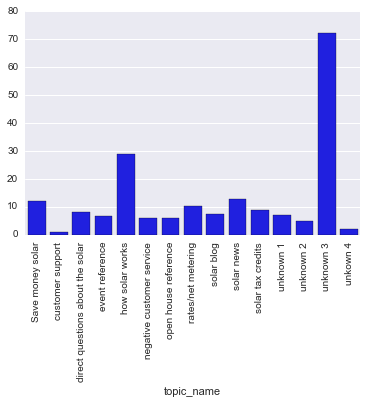

In [322]:
# long_tweets.groupby('topic')['retweet_count'].mean()
topic_to_mean_retweet = long_tweets.groupby('topic_name')['retweet_count'].sum() / long_tweets.groupby('topic_name')['retweet_count'].count()

ax = sns.barplot(x=topic_to_mean_retweet.index, y=topic_to_mean_retweet.values, color="b")

for item in ax.get_xticklabels():
    item.set_rotation(90)

# plt.xticks(rotation=45)
ax.figure.savefig('results/avg_retweets_by_topics.png')

## Visualizing marketing clusters

First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [1]:
vect = TfidfVectorizer(max_df = 0.8, 
                           max_features = 2000,
                           min_df = 5, 
                           stop_words = stop,
                           use_idf = True, 
                           tokenizer = None, 
                           ngram_range=(1, 3))
    
matrix = vect.fit_transform(docs)

NameError: name 'TfidfVectorizer' is not defined

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [ ]:
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]